In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import keras
import tensorflow.keras.backend as K
import model_function

## Generate digit 6x6 images

Define input images of digits

In [2]:
number_array = np.zeros((10, 5, 5), dtype=float)

# 0
number_array[0, 0, :] = 1  
number_array[0, :, 0] = 1 
number_array[0, :, 4] = 1  
number_array[0, 4, :] = 1  

# 1
number_array[1, :, 2] = 1 
number_array[1, 1, 1] = 1 
number_array[1, 4, 1:4] = 1  

# 2
number_array[2, 0, 1:-1] = 1  
number_array[2, 1, -1] = 1 
number_array[2, 1, 0] = 1  
number_array[2, 2, -2] = 1  
number_array[2, 3, 1:-2] = 1
number_array[2, 4, :] = 1  

# 3
number_array[3, 0, :] = 1  
number_array[3, 2, :] = 1  
number_array[3, 4, :] = 1  
number_array[3, :, -1] = 1  
number_array[3, 1, -1] = 1  

# 4
number_array[4, :, 4] = 1  
number_array[4, 0:3, 0] = 1  
number_array[4, 2, :] = 1  

# 5
number_array[5, 0, :] = 1  
number_array[5, 1, 0] = 1  
number_array[5, 2, :] = 1  
number_array[5, 3, -1] = 1  
number_array[5, 4, :] = 1  

# 6
number_array[6, 0, :] = 1  
number_array[6, 1, 0] = 1  
number_array[6, 2, :] = 1  
number_array[6, 3, -1] = 1  
number_array[6, 3, 0] = 1  
number_array[6, 4, :] = 1  

# 7
number_array[7, 0, :] = 1  
number_array[7, :, -1] = 1  

# 8
number_array[8, 0, :] = 1   
number_array[8, :, 0] = 1  
number_array[8, :, 4] = 1 
number_array[8, 2, :] = 1  
number_array[8, 4, :] = 1 
 

# 9
number_array[9, 0, :] = 1  
number_array[9, 4, :] = 1  
number_array[9, :, -1] = 1  
number_array[9, 2, :] = 1  
number_array[9, 1, 0] = 1 

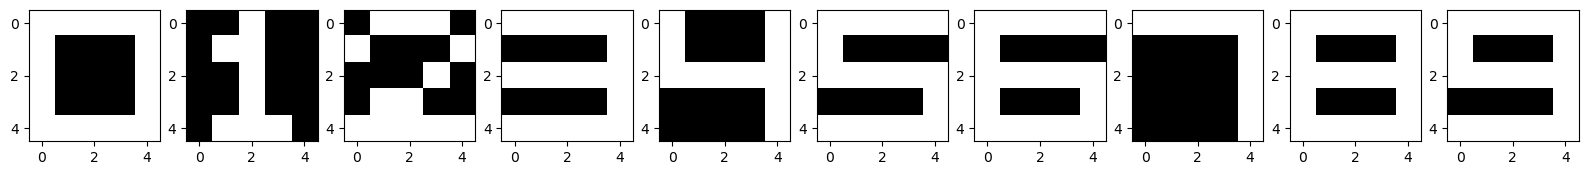

In [3]:
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(20,20))
for i,array in enumerate(number_array):
    axs[i].imshow(array, cmap='gray')

## Set Parameters

In [4]:
#times in ms
base_on_time= 50
on_time = 50
off_time= 20
#current in mA
baseline_current = 1.0
model_input_array = np.zeros((1,3), dtype=float)


test_index = 53452


Load ML model

In [7]:
load = True
model_path ='models/2024-04-17_12-35-13_single_step_41/model.h5'

if load:
    model = keras.models.load_model(model_path)

## Function definitions for image analysis

In [33]:
def pixel_to_signal_array(input:np.ndarray, base_on_time:int, on_time:int, off_time:int, modulation:float, max_int:int, linearize = False):
    if linearize:
        input = input.reshape(-1, input.shape[-1]**2)
    #normalize input to range [0,1]
    input = input.T/max_int
    
    #create output arrays of proper size
    output_current = np.zeros_like(input)
    
    #create auxiliary arrays to hold on/off times
    on_array =  np.zeros_like(input)
    off_array = np.zeros_like(input)
    

  
    
    #create auxiliary array with baseline current
    baseline_current_array = np.empty_like(input)
    baseline_current_array.fill(baseline_current)
    
    # set first on off time based on first column input
    for i, input_row in enumerate(input):
        on_array[i] = base_on_time+on_time*(input_row*modulation)
        off_array[i] = off_time+on_time*((1-input_row)*modulation)
        
        if i ==0: 
            model_input= np.stack([baseline_current_array[0,:], on_array[i], off_array[i]], axis=1)
            # print(i, model_input)
            # print(model.predict(model_input, verbose=0).flatten()) 
            # print(output_current[i,:]  )
            output_current[i,:] = model.predict(model_input, verbose=0).flatten()
            # print(output_current[i,:])
        else:
            model_input= np.stack([output_current[i-1], on_array[i], off_array[i]], axis=1)
            output_current[i,:] = model.predict(model_input, verbose=0).flatten()
        print(f'{i}/{input.shape[0]}', end='\r')      
             

    # Transpose back           
    return output_current.T, on_array.T, off_array.T

In [48]:
def draw_pulse_train_array(source_array,current,on_times,off_times, linearize = False):
    pulse_train = np.zeros((current.shape[0],off_times.shape[1]*2))
    # pulse_train = pulse_train.T
    pulse_train[:, ::2] = on_times
    pulse_train[:, 1::2] = off_times
    # pulse_train = pulse_train.T
    fig, axs = plt.subplots(pulse_train.shape[0],sharex= True, figsize=(10,3))
    for irow, row in enumerate(pulse_train):
        y_values = []
        for i,value in enumerate(row):
            if i%2==0:
                y_values.extend([1]*int(value))
            else:
                y_values.extend([0]*int(value))
        if linearize:
            axs.fill_between(range(len(y_values)),y_values, linestyle='-', label=irow)      
        else:
            axs[irow].fill_between(range(len(y_values)),y_values, linestyle='-', label=irow)  
        # plt.legend()
    plt.xlabel('Time (ms)')
    fig.supylabel('Signal')
    fig.suptitle('Device input signal per row')


    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3,3))
    axs.imshow(source_array, cmap='gray')
    axs.set_xlabel('Column count')
    axs.set_ylabel('Row count')
    axs.set_title('Source image')

    
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3,3))
    axs.imshow(current, cmap='inferno', aspect='auto')
    axs.set_xlabel('Pulse count')
    axs.set_ylabel('Row count')
    axs.set_title('Current heatmap')

 
    plt.figure(figsize=(10, 3))
    for i, row in enumerate(current):
        plt.plot(range(len(row)),row, marker='.', linestyle='-', label=i)  
    # plt.legend()
    plt.xlabel('Pulse count')
    plt.ylabel('Current (mA)')
    plt.title('Device output per row signal')

    

## Import MNIST database

In [28]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)



## Generate profiles for unedited image using 28 channels

In [31]:
#reduce one dimension to allow for array operations
x_train_reshape = x_train.reshape(-1, x_train.shape[-1])
print(x_train_reshape.shape)


(1680000, 28)


In [32]:
x_train_current, x_train_on, x_train_off = pixel_to_signal_array(x_train_reshape, base_on_time, on_time, off_time, modulation=1, max_int=255, linearize=False)

In [36]:
x_train_current_normal =  x_train_current.reshape((60000, 28, 28))
x_train_on_normal =  x_train_on.reshape((60000, 28, 28))
x_train_off_normal =  x_train_off.reshape((60000, 28, 28))

In [38]:
assert x_train_current_normal.shape == (60000, 28, 28)
assert x_train_on_normal.shape == (60000, 28, 28)
assert x_train_off_normal.shape == (60000, 28, 28)

In [40]:
#save normal ouput
with open('outputs/x_train_current_normal.npy', 'wb') as f:
    np.save(f, x_train_current_normal)
with open('outputs/x_train_on_normal.npy', 'wb') as f:
    np.save(f, x_train_on_normal)
with open('outputs/x_train_off_normal.npy', 'wb') as f:
    np.save(f, x_train_off_normal)

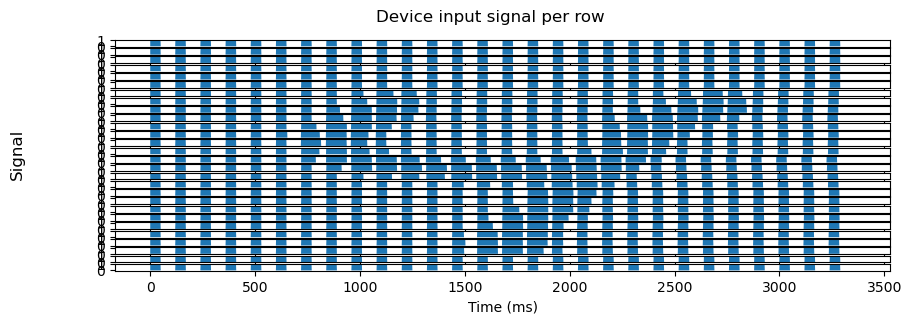

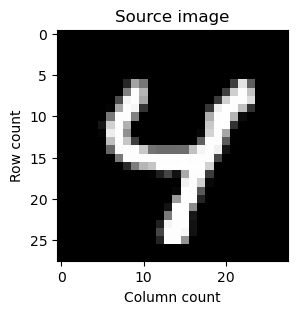

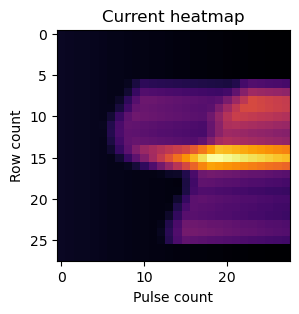

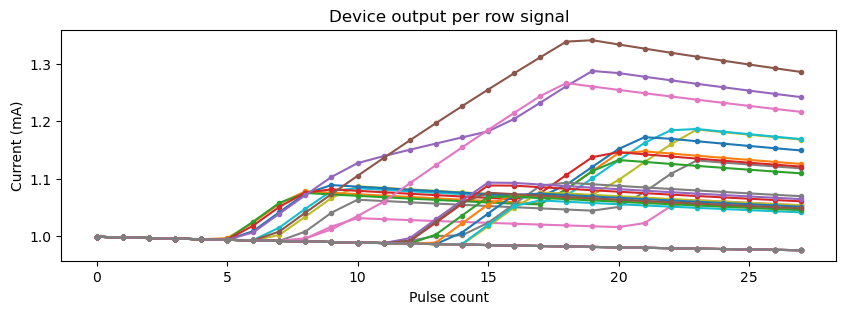

In [39]:
#check result
draw_pulse_train_array(x_train[test_index], x_train_current_normal[test_index], x_train_on_normal[test_index], x_train_off_normal[test_index], linearize=False)

## Reduce to one dimension: sequential

### Examples

In [50]:
# current_two,pulse_train_two = number_to_pulse_train_generator(number_array[2], base_on_time,on_time, off_time, modulation=1)
current_two,on_array_two, off_array_two = pixel_to_signal_array(number_array[2], base_on_time,on_time, off_time, modulation=1, max_int=1, linearize=True)

on_array_two.shape

(1, 25)

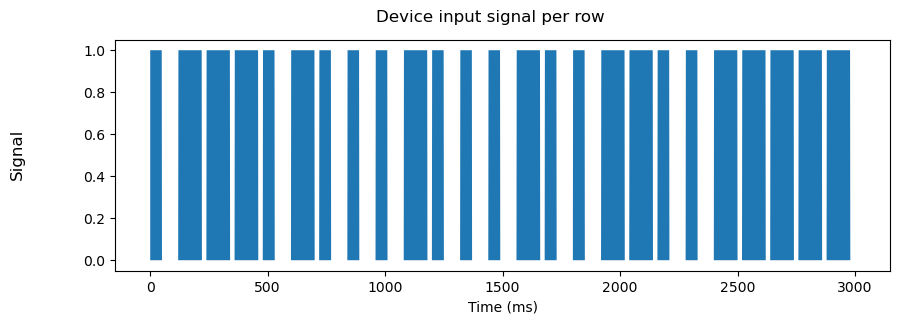

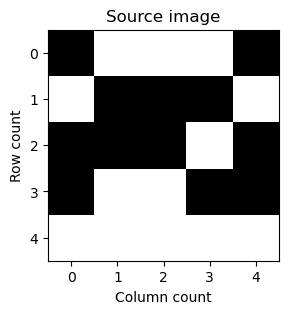

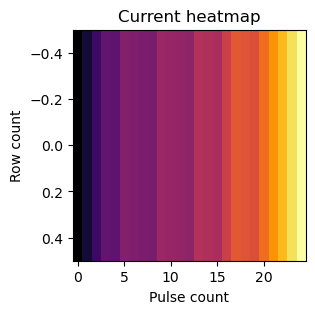

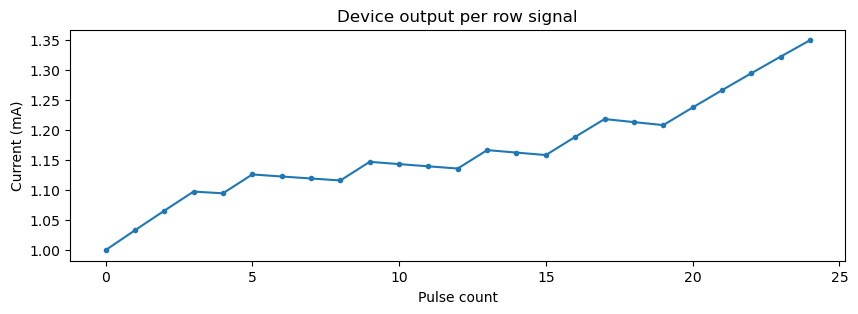

In [12]:
draw_pulse_train_array(number_array[2],current_two,on_array_two, off_array_two, linearize=True)

In [15]:
#try on MNIST dataset
x_train_current, x_train_on, x_train_off = pixel_to_signal_array(x_train[test_index], base_on_time, on_time, off_time, modulation=1, max_int=255, linearize=True)


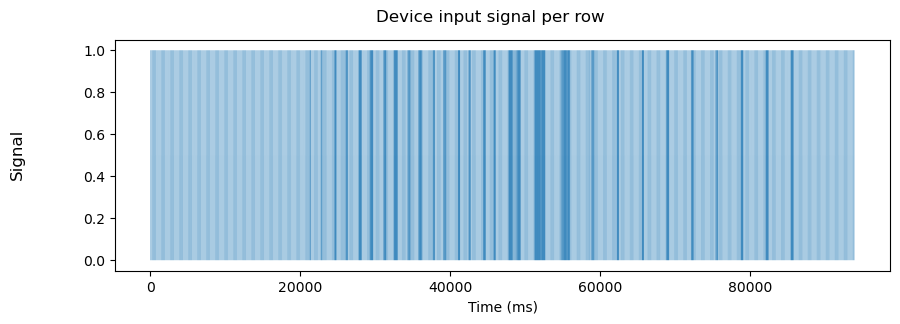

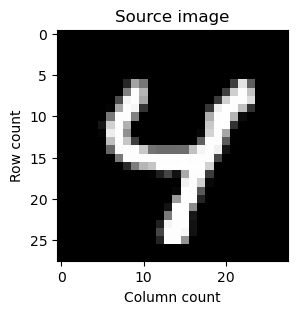

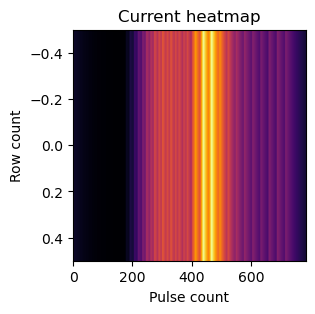

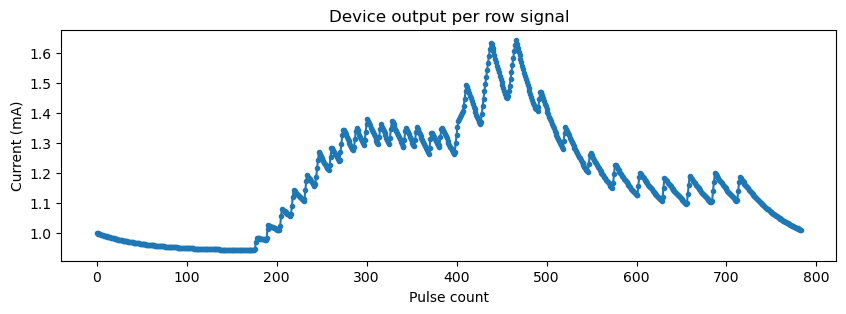

In [19]:
draw_pulse_train_array(x_train[test_index], x_train_current, x_train_on, x_train_off, linearize=True)

### Generate profiles

In [41]:
#generate output for linearized images
x_train_linearized = x_train.reshape(-1, x_train.shape[-1]**2)
print(x_train_linearized.shape)


(60000, 784)


In [42]:
x_train_current_linear, x_train_on_linear, x_train_off_linear = pixel_to_signal_array(x_train_linearized, base_on_time, on_time, off_time, modulation=1, max_int=255, linearize=False)

In [43]:
assert x_train_current_linear.shape == (60000, 28**2)
assert x_train_on_linear.shape == (60000, 28**2)
assert x_train_off_linear.shape == (60000, 28**2)

In [44]:
#save linearized ouput
with open('outputs/x_train_current_linearized.npy', 'wb') as f:
    np.save(f, x_train_current_linear)
with open('outputs/x_train_on_linearized.npy', 'wb') as f:
    np.save(f, x_train_on_linear)
with open('outputs/x_train_off_linearized.npy', 'wb') as f:
    np.save(f, x_train_off_linear)
# with open('outputs/y_train_pulstrain.npy', 'wb') as f:
#     np.save(f, x_train_small_pulsetrain)


check result

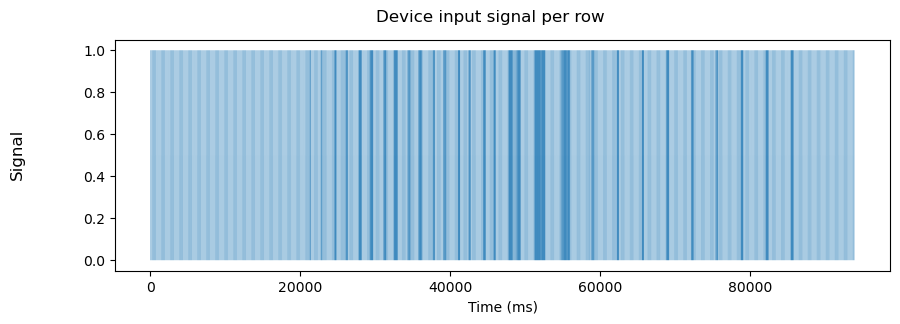

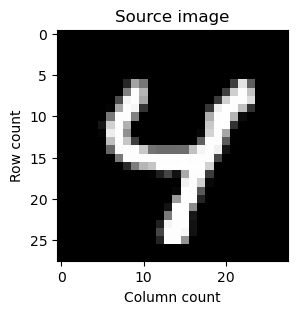

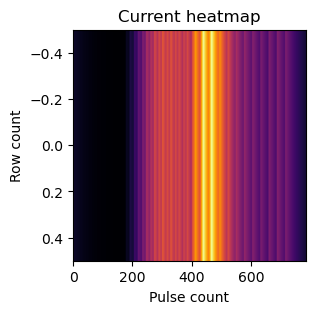

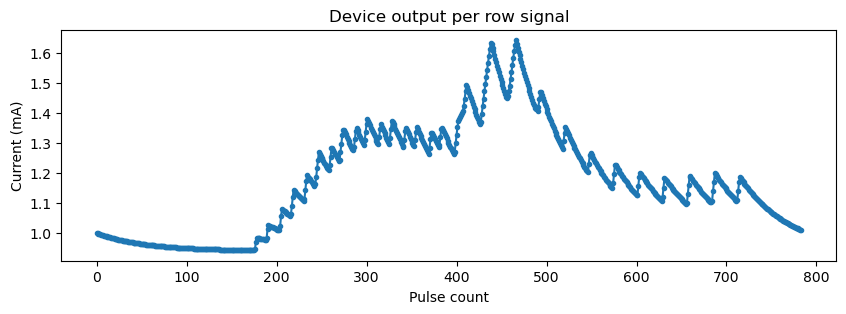

In [52]:
draw_pulse_train_array(x_train[test_index], np.expand_dims(x_train_current_linear[test_index], axis = 0), np.expand_dims(x_train_on_linear[test_index],axis = 0),np.expand_dims(x_train_off_linear[test_index],axis = 0), linearize=True)

## Reduce to one dimension: spiral pattern

### Examples

In [20]:
def unfold_spiral(array, target_array):
    if array.shape ==(0,0):
        target_array = np.expand_dims(target_array, axis=0)
        return target_array
    target_array = np.append(target_array, array[0,:])
    array = np.delete(array, 0, axis=0)
    array = np.rot90(array)
    return unfold_spiral(array, target_array)

In [23]:
array_empty = np.empty((1,0))
array_spiral = unfold_spiral(x_train[test_index], array_empty)


In [24]:

x_train_current_spiral_single, x_train_on_spiral_single, x_train_off_spiral_single = pixel_to_signal_array(array_spiral, base_on_time, on_time, off_time, modulation=1, max_int=255, linearize=False)


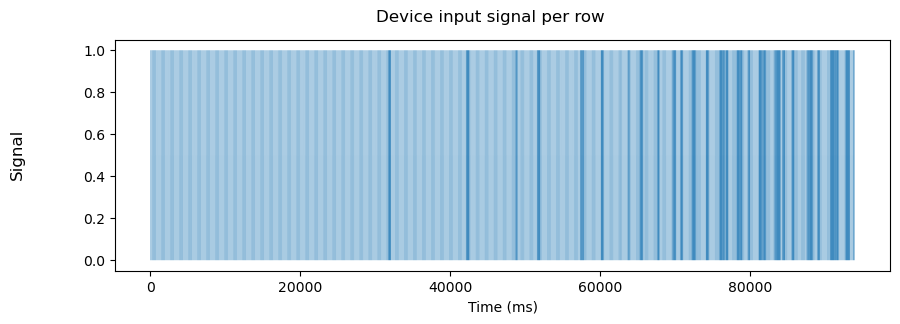

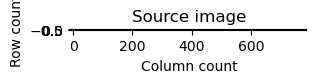

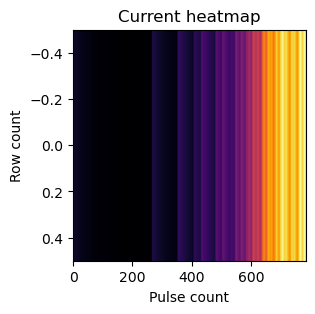

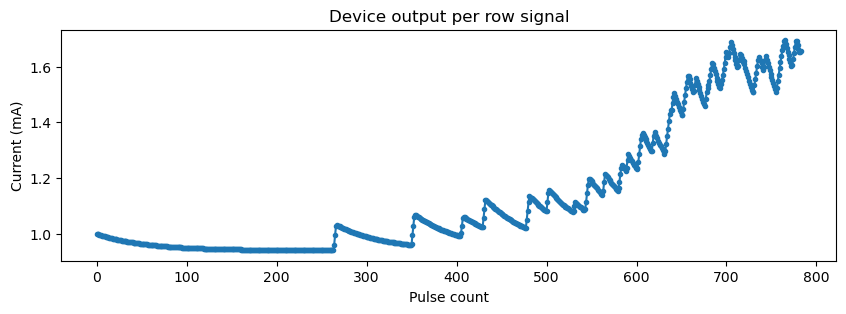

In [26]:
draw_pulse_train_array(array_spiral, x_train_current_spiral_single, x_train_on_spiral_single, x_train_off_spiral_single, linearize=True)

### Generate Profiles

In [53]:
#generate output for spiral unfolded images
x_train_spiral =np.zeros((x_train.shape[0],x_train.shape[1]**2))

for i, image in enumerate(x_train):
    print(i, end='\r')
    x_train_spiral[i] = unfold_spiral(x_train[i], array_empty)
print(x_train_spiral.shape)


(60000, 784)


In [54]:
x_train_current_spiral, x_train_on_spiral, x_train_off_spiral = pixel_to_signal_array(x_train_spiral, base_on_time, on_time, off_time, modulation=1, max_int=255, linearize=False)

In [55]:
assert x_train_current_spiral.shape == (60000, 28**2)
assert x_train_on_spiral.shape == (60000, 28**2)
assert x_train_off_spiral.shape == (60000, 28**2)

In [56]:
#save linearized ouput
with open('outputs/x_train_current_spiral.npy', 'wb') as f:
    np.save(f, x_train_current_spiral)
with open('outputs/x_train_on_spiral.npy', 'wb') as f:
    np.save(f, x_train_on_spiral)
with open('outputs/x_train_off_spiral.npy', 'wb') as f:
    np.save(f, x_train_off_spiral)
# with open('outputs/y_train_pulstrain.npy', 'wb') as f:
#     np.save(f, x_train_small_pulsetrain)

check result

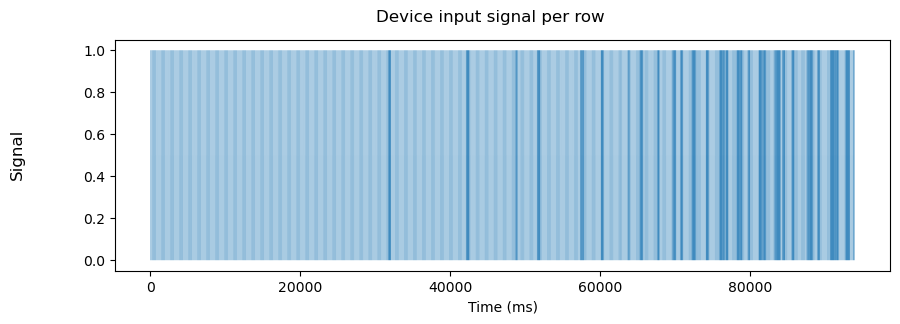

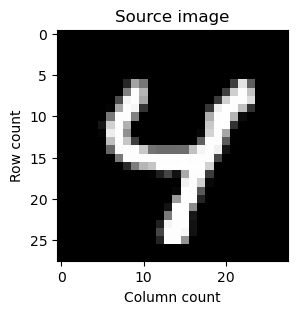

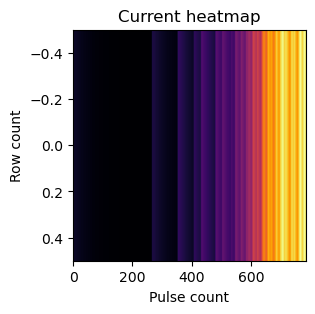

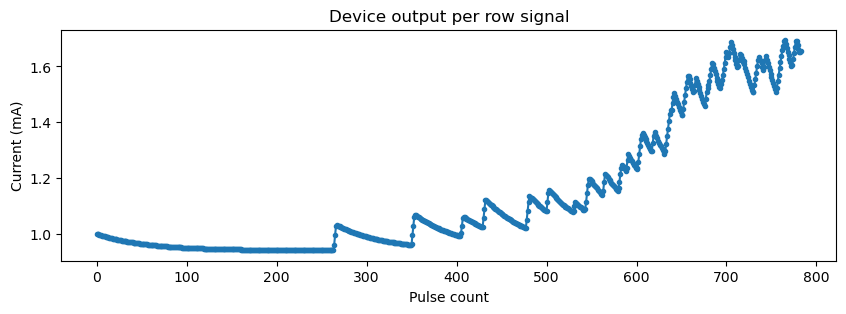

In [57]:
draw_pulse_train_array(x_train[test_index], np.expand_dims(x_train_current_spiral[test_index], axis = 0), np.expand_dims(x_train_on_spiral[test_index],axis = 0),np.expand_dims(x_train_off_spiral[test_index],axis = 0), linearize=True)